### Import packages and data

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
nfl_df = pd.read_csv('NFL_Play_by_Play_2009-2018_(v5).csv')

### Exploratory data analysis

In [5]:
nfl_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [6]:
nfl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449371 entries, 0 to 449370
Columns: 255 entries, play_id to defensive_extra_point_conv
dtypes: float64(135), int64(18), object(102)
memory usage: 874.2+ MB


In [7]:
#Listing columns for reference when selecting relevant features for this project
list(nfl_df.columns)

['play_id',
 'game_id',
 'home_team',
 'away_team',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential_post',
 'no_sc

In [8]:
#Creating a smaller dataframe for this project with relevant details
smaller_df = nfl_df[['play_id', 'game_id', 'home_team', 'away_team', 'posteam',
                     'defteam', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 
                     'half_seconds_remaining', 'game_seconds_remaining', 'drive', 'qtr', 
                     'down', 'ydstogo', 'play_type', 'posteam_timeouts_remaining',
                     'defteam_timeouts_remaining', 'posteam_score', 'defteam_score',
                     'score_differential']]

In [9]:
#Adding a column for game year
smaller_df['game_year'] = smaller_df['game_date'].str[:4]

In [10]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449371 entries, 0 to 449370
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     449371 non-null  int64  
 1   game_id                     449371 non-null  int64  
 2   home_team                   449371 non-null  object 
 3   away_team                   449371 non-null  object 
 4   posteam                     436129 non-null  object 
 5   defteam                     436492 non-null  object 
 6   yardline_100                436301 non-null  float64
 7   game_date                   449371 non-null  object 
 8   quarter_seconds_remaining   449230 non-null  float64
 9   half_seconds_remaining      449206 non-null  float64
 10  game_seconds_remaining      449208 non-null  float64
 11  drive                       449371 non-null  int64  
 12  qtr                         449371 non-null  int64  
 13  down          

In [11]:
num_games = len(set(smaller_df['game_id']))
print("The dataset contains details from " + str(num_games) + " games.")

The dataset contains details from 2526 games.


In [12]:
num_seasons = len(smaller_df.groupby('game_year').count()['play_id'])
num_plays = sum(smaller_df.groupby('game_year').count()['play_id'])
print("The dataset contains details from " + str(num_plays) + " plays.")
print("The dataset contains details from " + str(num_seasons) + " seasons.")

The dataset contains details from 449371 plays.
The dataset contains details from 10 seasons.


<AxesSubplot:xlabel='game_year'>

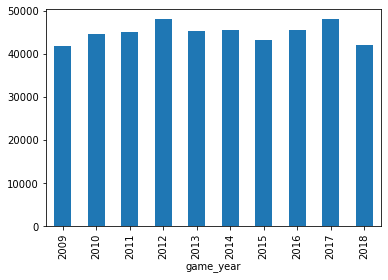

In [13]:
#Plotting the total number of plays per season
smaller_df.groupby('game_year').count()['play_id'].plot.bar()

In [14]:
smaller_df.groupby('play_type').count()['play_id']

play_type
extra_point     10934
field_goal       9777
kickoff         25552
no_play         42431
pass           186677
punt            23914
qb_kneel         3830
qb_spike          690
run            132692
Name: play_id, dtype: int64

<AxesSubplot:xlabel='play_type'>

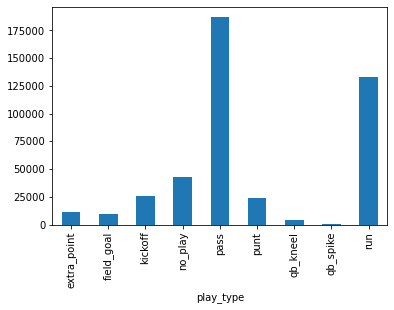

In [15]:
#Plotting the different types of plays
smaller_df.groupby('play_type').count()['play_id'].plot.bar()

In [16]:
#Creating a dataframe with only run or pass plays
run_pass = smaller_df[(smaller_df['play_type'] == 'run') | (smaller_df['play_type'] == 'pass')]

In [17]:
#Looking at correlation matrix
run_pass.corr()

,play_id,game_id,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,drive,qtr,down,ydstogo,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential
play_id,1.000000,0.009795,-0.054438,-0.244767,-0.469882,-0.982692,0.962659,0.957386,0.033446,0.004710,-0.310178,-0.296491,0.688590,0.706096,-0.063982
game_id,0.009795,1.000000,-0.002307,-0.005888,-0.003657,-0.002166,-0.023677,0.000897,-0.005424,0.005107,0.015653,0.014591,0.009407,0.019205,-0.009814
yardline_100,-0.054438,-0.002307,1.000000,0.095856,0.105960,0.068520,-0.013820,-0.044641,-0.072912,0.239956,0.060538,0.036272,-0.025564,-0.001010,-0.021199
quarter_seconds_remaining,-0.244767,-0.005888,0.095856,1.000000,0.561196,0.271404,-0.224336,-0.010821,-0.038000,0.005586,0.348068,0.298528,-0.149272,-0.188145,0.046679
half_seconds_remaining,-0.469882,-0.003657,0.105960,0.561196,1.000000,0.510420,-0.435204,-0.379075,-0.042611,0.004057,0.493640,0.461550,-0.307431,-0.345393,0.056764
game_seconds_remaining,-0.982692,-0.002166,0.068520,0.271404,0.510420,1.000000,-0.941269,-0.962694,-0.038196,0.000671,0.302179,0.289878,-0.669301,-0.686640,0.062498
drive,0.962659,-0.023677,-0.013820,-0.224336,-0.435204,-0.941269,1.000000,0.919471,0.017126,0.012482,-0.279761,-0.267319,0.661815,0.672699,-0.055938
qtr,0.957386,0.000897,-0.044641,-0.010821,-0.379075,-0.962694,0.919471,1.000000,0.029162,0.001032,-0.225455,-0.226392,0.656089,0.662231,-0.051106
down,0.033446,-0.005424,-0.072912,-0.038000,-0.042611,-0.038196,0.017126,0.029162,1.000000,-0.317494,-0.039669,-0.036567,0.006640,0.010117,-0.003705
ydstogo,0.004710,0.005107,0.239956,0.005586,0.004057,0.000671,0.012482,0.001032,-0.317494,1.000000,0.000515,0.005849,-0.004424,0.010712,-0.013852


<AxesSubplot:xlabel='qtr'>

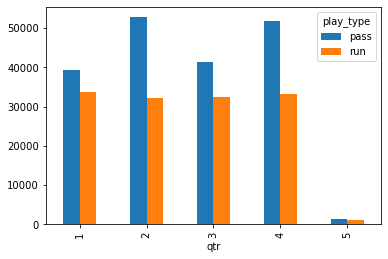

In [18]:
#Playcall by quarter
run_pass.groupby(['qtr', 'play_type',]).count()['play_id'].unstack().plot.bar()

<AxesSubplot:xlabel='down'>

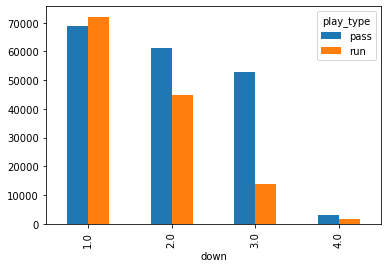

In [19]:
#Playcall by down
run_pass.groupby(['down', 'play_type',]).count()['play_id'].unstack().plot.bar()

In [20]:
#Adding column for if the team with the ball is ahead, behind, or tied
run_pass['lead'] = np.where(run_pass['score_differential']==0, 'tied', 0)
run_pass['lead'] = np.where(run_pass['score_differential']>0, 'ahead', run_pass['lead'])
run_pass['lead'] = np.where(run_pass['score_differential']<0, 'behind', run_pass['lead'])

In [21]:
#Checking to make sure values updated
run_pass.groupby('lead').count()['play_id']

lead
ahead     110306
behind    149610
tied       59453
Name: play_id, dtype: int64

<AxesSubplot:xlabel='lead'>

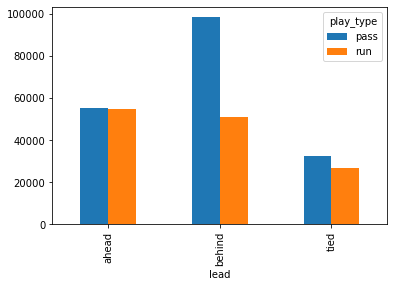

In [22]:
#Playcall by who is leading
run_pass.groupby(['lead', 'play_type',]).count()['play_id'].unstack().plot.bar()

<AxesSubplot:xlabel='game_year'>

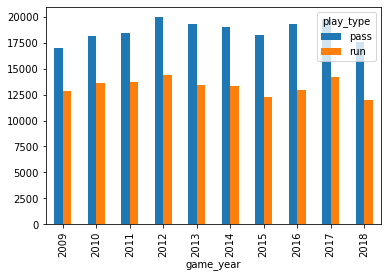

In [23]:
#Playcall by year
run_pass.groupby(['game_year', 'play_type',]).count()['play_id'].unstack().plot.bar()

In [24]:
run_pass_yr = run_pass.groupby(['game_year', 'play_type',]).count()['play_id'].unstack()

In [25]:
run_pass_yr['pass_percent'] = run_pass_yr['pass']/(run_pass_yr['pass']+run_pass_yr['run'])

In [26]:
run_pass_yr

play_type,pass,run,pass_percent
game_year,,,
2009,16941,12861,0.568452
2010,18170,13598,0.571959
2011,18457,13671,0.574483
2012,19954,14356,0.581580
2013,19298,13470,0.588928
2014,18981,13325,0.587538
2015,18211,12263,0.597591
2016,19309,12904,0.599416
2017,19756,14224,0.581401


In [27]:
#Playcall by team
run_pass_team = run_pass.groupby(['posteam', 'play_type',]).count()['play_id'].unstack()

In [28]:
run_pass_team['pass_percent'] = run_pass_team['pass']/(run_pass_team['pass']+run_pass_team['run'])

In [29]:
run_pass_team.sort_values('pass_percent')

play_type,pass,run,pass_percent
posteam,,,
NYJ,5428,4665,0.537798
CAR,5395,4551,0.542429
SEA,5339,4456,0.545074
BUF,5390,4466,0.546875
SF,5360,4286,0.555671
KC,5478,4353,0.557217
HOU,5782,4545,0.559892
TEN,5398,4115,0.567434
CIN,5623,4285,0.567521


<AxesSubplot:xlabel='posteam'>

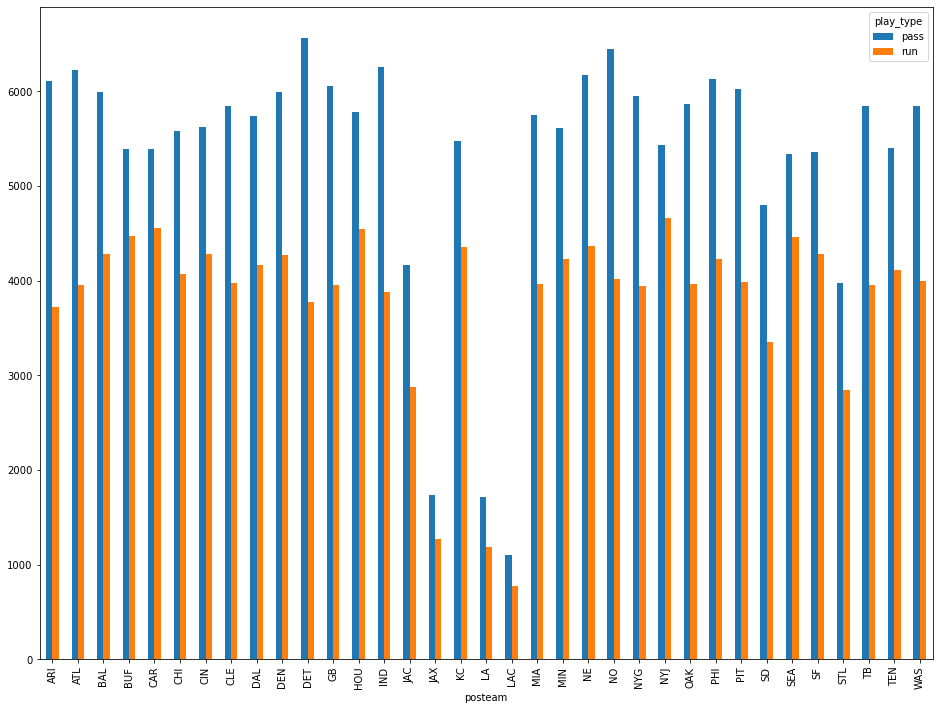

In [30]:
#Playcall by team
run_pass.groupby(['posteam', 'play_type',]).count()['play_id'].unstack().plot.bar(figsize=(16,12))

### Data cleaning

In [31]:
run_pass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319369 entries, 1 to 449368
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     319369 non-null  int64  
 1   game_id                     319369 non-null  int64  
 2   home_team                   319369 non-null  object 
 3   away_team                   319369 non-null  object 
 4   posteam                     319369 non-null  object 
 5   defteam                     319369 non-null  object 
 6   yardline_100                319369 non-null  float64
 7   game_date                   319369 non-null  object 
 8   quarter_seconds_remaining   319369 non-null  float64
 9   half_seconds_remaining      319352 non-null  float64
 10  game_seconds_remaining      319355 non-null  float64
 11  drive                       319369 non-null  int64  
 12  qtr                         319369 non-null  int64  
 13  down          

Since there are only a few missing values (half_seconds_remaining, game_seconds_remaining, down), it is okay to drop these values without affecting our analysis.

In [32]:
run_pass.dropna(inplace = True)

In [33]:
run_pass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318668 entries, 1 to 449368
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     318668 non-null  int64  
 1   game_id                     318668 non-null  int64  
 2   home_team                   318668 non-null  object 
 3   away_team                   318668 non-null  object 
 4   posteam                     318668 non-null  object 
 5   defteam                     318668 non-null  object 
 6   yardline_100                318668 non-null  float64
 7   game_date                   318668 non-null  object 
 8   quarter_seconds_remaining   318668 non-null  float64
 9   half_seconds_remaining      318668 non-null  float64
 10  game_seconds_remaining      318668 non-null  float64
 11  drive                       318668 non-null  int64  
 12  qtr                         318668 non-null  int64  
 13  down          

In [34]:
#Consolidating data for teams that changed their names
conditions = [run_pass['home_team'] == 'JAC', run_pass['home_team'] == 'STL', run_pass['home_team'] == 'SD']

choices = ['JAX', 'LA', 'LAC']

run_pass['home_team'] = np.select(conditions, choices, default = run_pass['home_team'])

In [35]:
conditions = [run_pass['away_team'] == 'JAC', run_pass['away_team'] == 'STL', run_pass['away_team'] == 'SD']

choices = ['JAX', 'LA', 'LAC']

run_pass['away_team'] = np.select(conditions, choices, default = run_pass['away_team'])

In [36]:
conditions = [run_pass['posteam'] == 'JAC', run_pass['posteam'] == 'STL', run_pass['posteam'] == 'SD']

choices = ['JAX', 'LA', 'LAC']

run_pass['posteam'] = np.select(conditions, choices, default = run_pass['posteam'])

In [37]:
conditions = [run_pass['defteam'] == 'JAC', run_pass['defteam'] == 'STL', run_pass['defteam'] == 'SD']

choices = ['JAX', 'LA', 'LAC']

run_pass['defteam'] = np.select(conditions, choices, default = run_pass['defteam'])

### Preparing data for first simple models

In [38]:
#defining run play as 0 and pass play as 1
run_pass['pass'] = np.where(run_pass['play_type']=='pass', 1, 0)

In [39]:
#picking features for simple model
numeric_features = ['yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', \
                    'game_seconds_remaining', 'drive', 'qtr', 'down', 'ydstogo', \
                    'posteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential']

In [40]:
X = run_pass[numeric_features]

In [41]:
y = run_pass['pass']

In [42]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)

### Building dummy model

In [43]:
#dummy model
dummy_model = DummyClassifier(strategy="most_frequent")

In [44]:
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

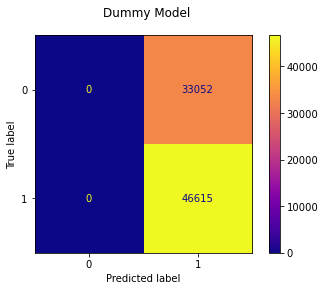

In [45]:
#confusion matrix for test data
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_test, y_test, ax=ax, cmap="plasma");

In [46]:
#accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, dummy_model.predict(X_test))

0.5851230747988502

In [47]:
#precision
from sklearn.metrics import precision_score
precision_score(y_test, dummy_model.predict(X_test))

0.5851230747988502

In [48]:
#recall
from sklearn.metrics import recall_score
recall_score(y_test, dummy_model.predict(X_test))

1.0

In [49]:
#f1
from sklearn.metrics import f1_score
f1_score(y_test, dummy_model.predict(X_test))

0.7382683201089625

### Building a simple logistic regression model

In [50]:
simple_logreg_model = LogisticRegression(random_state=2021, penalty='none', max_iter = 500)

In [51]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [52]:
simple_logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=500, penalty='none', random_state=2021)

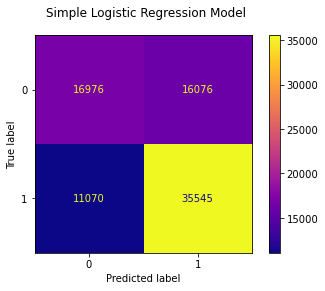

In [53]:
#confusion matrix for test data
fig, ax = plt.subplots()

fig.suptitle("Simple Logistic Regression Model")

plot_confusion_matrix(simple_logreg_model, X_test, y_test, ax=ax, cmap="plasma");

In [54]:
#accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, simple_logreg_model.predict(X_test))

0.6592566558298919

In [55]:
#precision
from sklearn.metrics import precision_score
precision_score(y_test, simple_logreg_model.predict(X_test))

0.6885763545843746

In [56]:
#recall
from sklearn.metrics import recall_score
recall_score(y_test, simple_logreg_model.predict(X_test))

0.7625227930923523

In [57]:
#f1
from sklearn.metrics import f1_score
f1_score(y_test, simple_logreg_model.predict(X_test))

0.7236654586913147

### Feature engineering

In [58]:
run_pass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318668 entries, 1 to 449368
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     318668 non-null  int64  
 1   game_id                     318668 non-null  int64  
 2   home_team                   318668 non-null  object 
 3   away_team                   318668 non-null  object 
 4   posteam                     318668 non-null  object 
 5   defteam                     318668 non-null  object 
 6   yardline_100                318668 non-null  float64
 7   game_date                   318668 non-null  object 
 8   quarter_seconds_remaining   318668 non-null  float64
 9   half_seconds_remaining      318668 non-null  float64
 10  game_seconds_remaining      318668 non-null  float64
 11  drive                       318668 non-null  int64  
 12  qtr                         318668 non-null  int64  
 13  down          

In [59]:
#Adding feature if team is in the red zone
run_pass['red_zone'] = np.where(run_pass['yardline_100']<=20, 1, 0)

In [60]:
#Adding feature for two minute drill
run_pass['two_min'] = np.where(run_pass['half_seconds_remaining']<=120, 1, 0)

In [61]:
run_pass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318668 entries, 1 to 449368
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     318668 non-null  int64  
 1   game_id                     318668 non-null  int64  
 2   home_team                   318668 non-null  object 
 3   away_team                   318668 non-null  object 
 4   posteam                     318668 non-null  object 
 5   defteam                     318668 non-null  object 
 6   yardline_100                318668 non-null  float64
 7   game_date                   318668 non-null  object 
 8   quarter_seconds_remaining   318668 non-null  float64
 9   half_seconds_remaining      318668 non-null  float64
 10  game_seconds_remaining      318668 non-null  float64
 11  drive                       318668 non-null  int64  
 12  qtr                         318668 non-null  int64  
 13  down          

In [62]:
rp_df = pd.get_dummies(run_pass, columns = ['qtr', 'down', 'posteam', 'defteam', 'lead'], drop_first = True)

In [63]:
rp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318668 entries, 1 to 449368
Data columns (total 92 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     318668 non-null  int64  
 1   game_id                     318668 non-null  int64  
 2   home_team                   318668 non-null  object 
 3   away_team                   318668 non-null  object 
 4   yardline_100                318668 non-null  float64
 5   game_date                   318668 non-null  object 
 6   quarter_seconds_remaining   318668 non-null  float64
 7   half_seconds_remaining      318668 non-null  float64
 8   game_seconds_remaining      318668 non-null  float64
 9   drive                       318668 non-null  int64  
 10  ydstogo                     318668 non-null  int64  
 11  play_type                   318668 non-null  object 
 12  posteam_timeouts_remaining  318668 non-null  float64
 13  defteam_timeou

### Checking accuracy on random forest, decision tree, and logistic regression with new features

In [64]:
X = rp_df.drop(columns = ['play_id', 'game_id', 'home_team', 'away_team',
                         'game_date', 'play_type', 'game_year', 'pass'])

In [65]:
y = rp_df['pass']

In [66]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)

In [67]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [68]:
names = ['Logistic Regression', 'Random Forest', 'Decision Tree']

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
from sklearn.tree import DecisionTreeClassifier

In [71]:
classifiers = [LogisticRegression(random_state=2021, penalty='none', max_iter = 500), 
              RandomForestClassifier(max_depth = 5, n_estimators = 100),
              DecisionTreeClassifier(max_depth = 5)]

In [72]:
scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)

In [73]:
scores

[0.6650055857506872, 0.63988853603123, 0.6611771498864022]

### Grid search with Random Forest

In [23]:
from sklearn.model_selection import GridSearchCV

In [38]:
param_grid = { 
    'n_estimators': [100, 250],
    "min_samples_leaf": [5, 10, 15],
    'max_leaf_nodes':[20, 35, 50],
}

In [39]:
grid_tree=GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [40]:
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 32.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_leaf_nodes': [20, 35, 50],
                         'min_samples_leaf': [5, 10, 15],
                         'n_estimators': [100, 250]},
             scoring='accuracy', verbose=1)

In [41]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)
#Identify the best score during fitting with cross-validation

0.6675243983533896
{'max_leaf_nodes': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=5)


### Grid search with a Decision Tree

In [47]:
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, None],
    'max_features': ['auto', None, 25, 100],
    'class_weight': [None, 'balanced']
}

In [48]:
grid_tree=GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [49]:
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 880 out of 880 | elapsed: 11.1min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20,
                                       None],
                         'max_features': ['auto', None, 25, 100]},
             scoring='accuracy', verbose=1)

In [50]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)
#Identify the best score during fitting with cross-validation

0.6904071428802763
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'max_features': None}
DecisionTreeClassifier(criterion='entropy', max_depth=12)


### Grid search with XGBoost

In [74]:
import xgboost

In [52]:
param_grid = { 
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, None],
    'booster': ['gbtree', 'gblinear', 'dart']
}

In [55]:
grid_tree=GridSearchCV(xgboost.XGBClassifier(objective='binary:logistic'), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [56]:
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 48.2min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [57]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)
#Identify the best score during fitting with cross-validation

0.7013443356824787
{'booster': 'gbtree', 'max_depth': 5, 'n_estimators': 100}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


### Selecting best model based on accuracy

In [75]:
BestModel = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [76]:
BestModel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

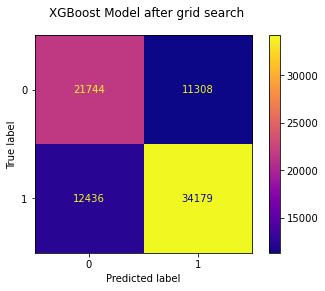

In [77]:
#confusion matrix for test data
fig, ax = plt.subplots()

fig.suptitle("XGBoost Model after grid search")

plot_confusion_matrix(BestModel, X_test, y_test, ax=ax, cmap="plasma");

In [78]:
#accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, BestModel.predict(X_test))

0.7019594060275899

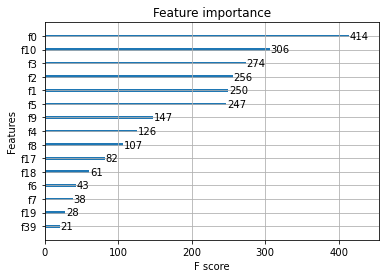

In [79]:
#Checking feature importance for model
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(BestModel, max_num_features=15) # top 10 most important features
plt.show()

In [80]:
#Listing feature names
list(X.columns)

['yardline_100',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'drive',
 'ydstogo',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'red_zone',
 'two_min',
 'qtr_2',
 'qtr_3',
 'qtr_4',
 'qtr_5',
 'down_2.0',
 'down_3.0',
 'down_4.0',
 'posteam_ATL',
 'posteam_BAL',
 'posteam_BUF',
 'posteam_CAR',
 'posteam_CHI',
 'posteam_CIN',
 'posteam_CLE',
 'posteam_DAL',
 'posteam_DEN',
 'posteam_DET',
 'posteam_GB',
 'posteam_HOU',
 'posteam_IND',
 'posteam_JAX',
 'posteam_KC',
 'posteam_LA',
 'posteam_LAC',
 'posteam_MIA',
 'posteam_MIN',
 'posteam_NE',
 'posteam_NO',
 'posteam_NYG',
 'posteam_NYJ',
 'posteam_OAK',
 'posteam_PHI',
 'posteam_PIT',
 'posteam_SEA',
 'posteam_SF',
 'posteam_TB',
 'posteam_TEN',
 'posteam_WAS',
 'defteam_ATL',
 'defteam_BAL',
 'defteam_BUF',
 'defteam_CAR',
 'defteam_CHI',
 'defteam_CIN',
 'defteam_CLE',
 'defteam_DAL',
 'defteam_DEN',
 'defteam_DET',
 'd

### Data visualizations

In [81]:
#train/test split without scaler
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)

In [82]:
BestModel2 = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [83]:
BestModel2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
y_pred = BestModel2.predict(X_test)

In [85]:
X_test['pred']=y_pred.tolist()

In [86]:
X_test['actual'] = y_test

In [87]:
X_test.reset_index(inplace = True)

<AxesSubplot:xlabel='yardline_100', ylabel='index'>

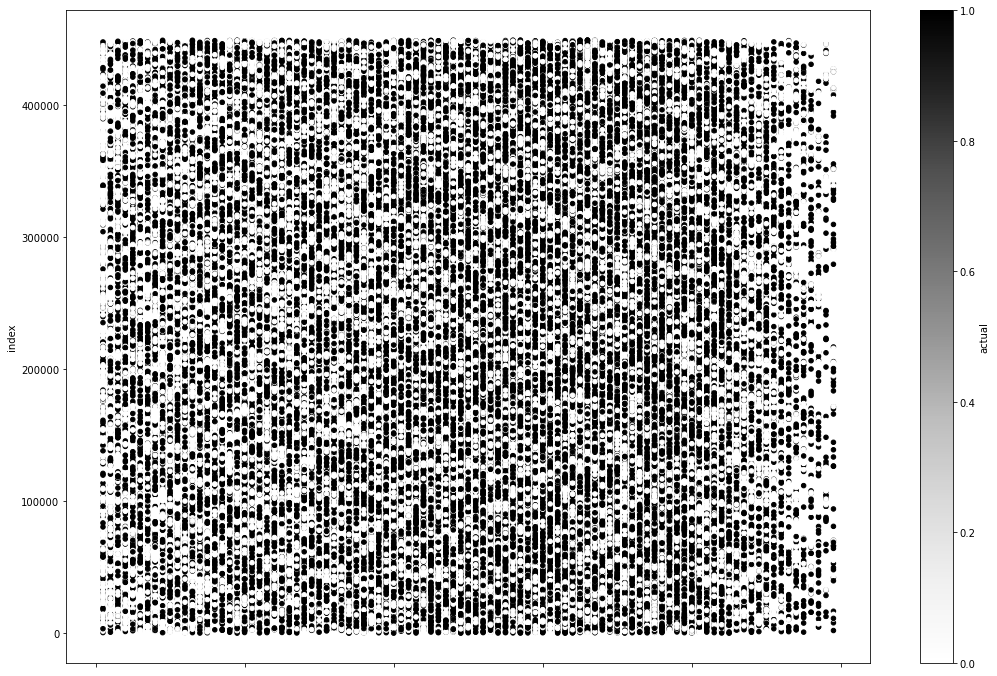

In [88]:
#Viewing scatter plot of run versus pass plays in the test data
X_test.plot.scatter('yardline_100', 'index', figsize=(18,12), c='actual')

In [89]:
X_test['colors'] = np.where((X_test['pred']==1) & (X_test['actual']==1), 'b', 0)

In [90]:
X_test['colors'] = np.where((X_test['pred']==1) & (X_test['actual']==0), 'r', X_test['colors'])

In [91]:
X_test['colors'] = np.where((X_test['pred']==0) & (X_test['actual']==0), 'g', X_test['colors'])

In [92]:
X_test['colors'] = np.where((X_test['pred']==0) & (X_test['actual']==1), 'y', X_test['colors'])

<AxesSubplot:xlabel='yardline_100', ylabel='index'>

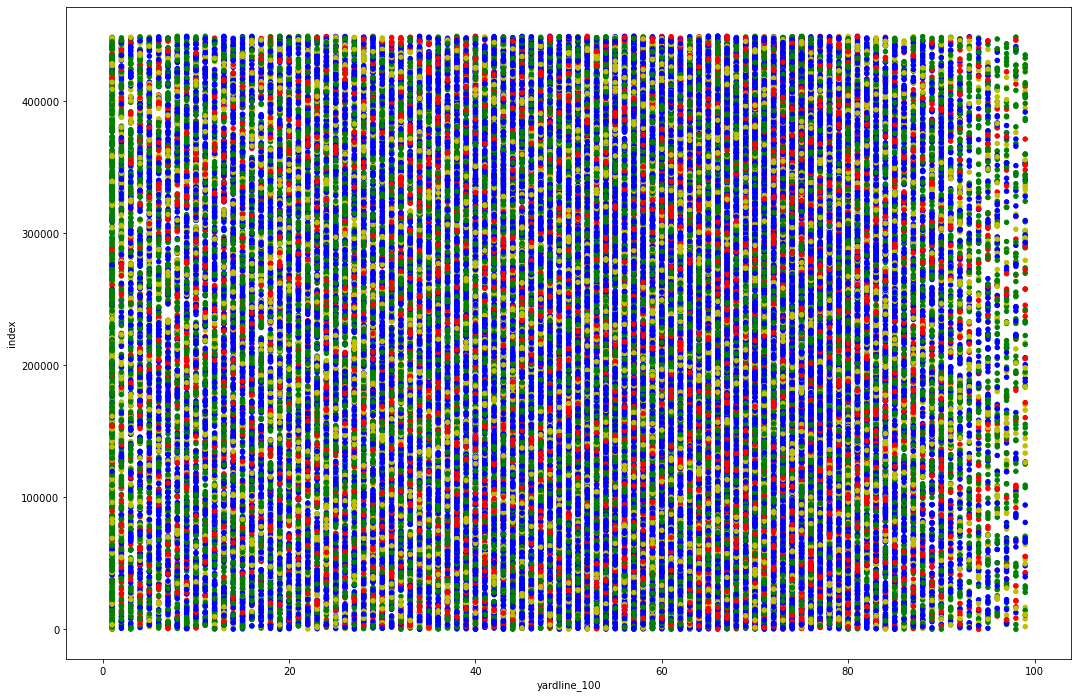

In [93]:
#Viewing a scatter plot of run versus pass plays with prediction accuracy in the test data
X_test.plot.scatter('yardline_100', 'index', figsize=(18,12), c='colors')

In [94]:
#Preparing data for a graph of passing percentage (acutal v model preidcitions on test data)
yard = X_test.groupby('yardline_100').sum()[['pred', 'actual']]

In [95]:
yard_total = X_test.groupby('yardline_100').count()['index']

In [96]:
yard['total'] = yard_total

In [97]:
yard['pred_percent']=yard['pred']/yard['total']

In [98]:
yard['actual_percent']=yard['actual']/yard['total']

In [99]:
yard.reset_index(inplace = True)

<AxesSubplot:xlabel='yardline_100'>

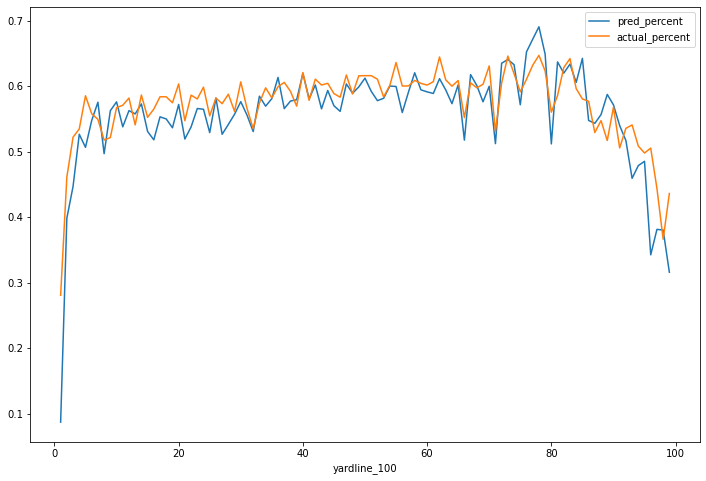

In [100]:
#Plotting passing percentage by field position (acutal v model preidcitions on test data)
yard.plot.line('yardline_100', ['pred_percent', 'actual_percent'], figsize = (12,8))

In [101]:
#Preparing data for analysis of play calling by quarter and score
X_test['qtr_1'] = np.where((X_test['qtr_2']==0) & (X_test['qtr_3']==0) & (X_test['qtr_4']==0) & (X_test['qtr_5']==0), 1, 0)

In [102]:
df_score_by_qtr = X_test[['score_differential', 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4', 'qtr_5', 'pred', 'actual']]

In [103]:
df_score_by_qtr['score_differential'] = np.where(df_score_by_qtr['score_differential'] < -14, -15, df_score_by_qtr['score_differential'])

In [104]:
df_score_by_qtr['score_differential'] = np.where(df_score_by_qtr['score_differential'] > 14, 15, df_score_by_qtr['score_differential'])

In [105]:
df_score_by_qtr['quarter'] = np.where(df_score_by_qtr['qtr_1']==1,1,0)

In [106]:
df_score_by_qtr['quarter'] = np.where(df_score_by_qtr['qtr_2']==1,2,df_score_by_qtr['quarter'])

In [107]:
df_score_by_qtr['quarter'] = np.where(df_score_by_qtr['qtr_3']==1,3,df_score_by_qtr['quarter'])

In [108]:
df_score_by_qtr['quarter'] = np.where(df_score_by_qtr['qtr_4']==1,4,df_score_by_qtr['quarter'])

In [109]:
df_score_by_qtr = df_score_by_qtr[df_score_by_qtr['qtr_5'] != 1]

In [110]:
df_score_by_qtr.groupby(['score_differential', 'quarter']).mean()['actual'].unstack().sort_values('score_differential')

quarter,1,2,3,4
score_differential,,,,
-15.0,0.465517,0.701807,0.668053,0.787785
-14.0,0.545455,0.663212,0.637255,0.801460
-13.0,0.560000,0.703614,0.629454,0.819417
-12.0,0.454545,0.699115,0.573684,0.838150
-11.0,0.577778,0.673759,0.601050,0.853211
-10.0,0.521277,0.648569,0.580345,0.789340
-9.0,0.569444,0.659459,0.611538,0.842520
-8.0,0.833333,0.623016,0.592742,0.785326
-7.0,0.548077,0.609326,0.523913,0.738070


In [111]:
data = df_score_by_qtr.groupby(['score_differential', 'quarter']).mean()['actual'].unstack()

In [112]:
import seaborn as sns

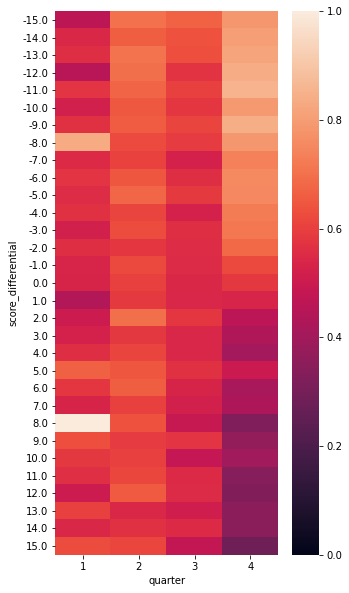

In [113]:
#Plot heatmap for actual results
plt.figure(figsize = (5, 10))
ax = sns.heatmap(data, vmin=0, vmax=1)

In [114]:
data2 = df_score_by_qtr.groupby(['score_differential', 'quarter']).mean()['pred'].unstack()

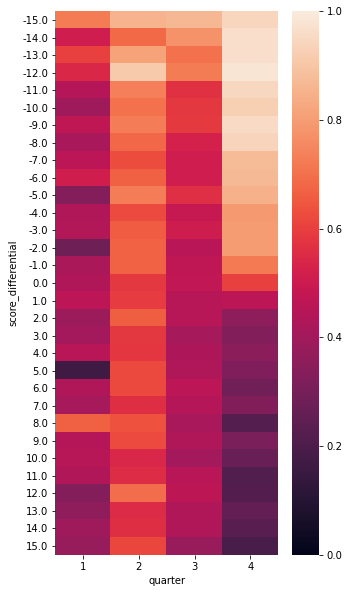

In [115]:
#Plot heatmap for predicted results
plt.figure(figsize = (5, 10))
ax = sns.heatmap(data2, vmin=0, vmax=1)